In [79]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [80]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import graphviz as gr

In [81]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)


def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y


def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [82]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)


def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)    
    
    
def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

# 1. Experiment with covariates

## Simulate a DGP

In [83]:
np.random.seed(7)
T = np.random.binomial(1, 0.4, 1500)
X = np.random.normal(16,8,1500)
Y = np.random.normal(3 + 5*T + 2*X, 3).astype(int)
datacov = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
datacov.to_csv("datacov.csv", index=False)

## DAG

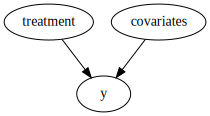

In [84]:
g = gr.Digraph()
g.edge("treatment", "y")
g.edge("covariates", "y")
g

### a. You do not control for any covariates

In [85]:
tau = 5
corr = 0.5
conf = False
p = 10
p0 = 5
N = 1000

In [86]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 182.31it/s]


In [87]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.00509644220867979, RMSE=0.2106475717820159, size=0.072
N=1000: bias=0.002530775974719494, RMSE=0.062246501438701904, size=0.051


### b. You control for all the covariates that affect the outcome

In [88]:
estDict = {}
R = 1000
flagX = 1
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        mod = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1))
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


In [89]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.002155984201206686, RMSE=0.21026332074861676, size=0.061
N=1000: bias=-0.0049673904906797255, RMSE=0.060919682984843876, size=0.044


## Example

y: education 

treatment: education cash transfer to households (to encourage education)  

covariates: age, gender (uncorrelated with the treatment)

# 2. Experiment with a confounder

## Simulate a DGP

In [90]:
np.random.seed(7)
X = np.random.normal(16,8,1500)
T = np.random.binomial(1, 1/(2+X**2), 1500)
Y = np.random.normal(3 + 5*T + 2*X, 3).astype(int)
dataconf = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
dataconf.to_csv("dataconf.csv", index=False)

## DAG

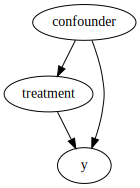

In [91]:
g = gr.Digraph()
g.edge("treatment", "y")
g.edge("confounder","treatment")
g.edge("confounder","y")
g

### a. You fail to control for the confounder

In [92]:
def fn_generate_data_conf(tau,N,p,corr,conf = True):
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    if conf==False:
        conf_mult = 0
    else:
        conf_mult = 1 
        
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    
    return (Yab,T,C)

In [93]:
tau = 5
corr = 0.5
p = 10
N = 1000
conf = True

In [94]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,C = fn_generate_data_conf(tau,N,p,corr)
        mod = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 172.20it/s]


In [95]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.012504013725042711, RMSE=8.305823750062967, size=0.058
N=1000: bias=0.020409954555835823, RMSE=2.541150982227619, size=0.042


### b. You do control for the confounder

In [96]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,C = fn_generate_data_conf(tau,N,p,corr)
        mod = sm.OLS(Yexp,np.concatenate([T,C,const],axis = 1))
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 173.84it/s]


In [97]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.13482034317643987, RMSE=5.905420041634713, size=0.042
N=1000: bias=0.014270608780753261, RMSE=1.8783948012049756, size=0.049


## Example

y: employment status

treatment: job training 

confounders: enterprising personality

# 3. Experiment with a selection bias

## Simulate a DGP

In [98]:
np.random.seed(7)
T = np.random.binomial(1, 0.4, 1500)
Y = np.random.normal(3 + 5*T, 3).astype(int)
X = np.random.normal(7+np.mean(T)*np.mean(Y),3,1500)
databias = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
databias.to_csv("databias.csv", index=False)

## DAG

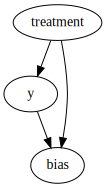

In [99]:
g = gr.Digraph()
g.edge("treatment", "y")
g.edge("treatment","bias")
g.edge("y","bias")
g

### a. You control for the variable in between the path from cause to effect

In [100]:
def fn_generate_data_bias(tau,N,p,corr):

    nvar = p+1 
    corr = 0.5 
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    u = np.random.normal(0,1,[N,1])
    Yab = tau*T+err
    Bab = 0.2*T+0.6*Yab+u

    return (Yab,T,Bab)

In [101]:
tau = 5
corr = .5
p = 10
N = 1000

In [102]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,B = fn_generate_data_bias(tau,N,p,corr)
        mod = sm.OLS(Yexp,np.concatenate([T,B,const],axis = 1))
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 175.87it/s]


In [103]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-1.412800985468613, RMSE=1.444057461064614, size=0.996
N=1000: bias=-1.4154562528916956, RMSE=1.4186072662220746, size=1.0


### b. You do not control for the variable in between the path from cause to effect

In [104]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,B = fn_generate_data_bias(tau,N,p,corr)
        mod = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 172.48it/s]


In [105]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0001322326668914915, RMSE=0.1984563143185186, size=0.051
N=1000: bias=-0.0009308912756163661, RMSE=0.06376588588676245, size=0.049


## Example

y: weight loss

treatment: online fitness tutorial

selection: self-report in the comments

（Those who do not have significant weight loss are likely not to report in the comment and may not participate the entire tutorial)